# Import required packages

In [1]:
from datasets import Dataset
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import sklearn
from sklearn.metrics import f1_score
from transformers import  BertForSequenceClassification
from datasets import  load_metric
from sklearn.metrics import classification_report
import torch
import random
torch.cuda.empty_cache()
import matplotlib.pyplot as plt
##Set random values
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

# GPU or CPU

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


# Datasets

In [3]:
train_df = pd.read_json("E:/subtaskB_train.jsonl", lines=True)
test_df = pd.read_json("E:/subtaskB_dev.jsonl", lines=True)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42) # %80 train, %20 validation
id2label = {0: 'human', 1: 'chatGPT', 2: 'cohere', 3: 'davinci', 4: 'bloomz', 5: 'dolly'}
label2id = {'human': 0, 'chatGPT': 1,'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}

In [4]:
train_df

,text,model,source,label,id
63795,We report on observations made with the Spitze...,bloomz,arxiv,4,63795
52761,The concept of dynamical 3-space is introduced...,bloomz,arxiv,4,52761
17690,The European Association for Digital Humaniti...,davinci,wikipedia,3,17690
38189,We study theoretically the emission and absorp...,bloomz,arxiv,4,38189
18742,"Stranger in the City, also known as S.I.T.C, ...",davinci,wikipedia,3,18742
...,...,...,...,...,...
31671,The chiral condensate is an important order pa...,dolly,arxiv,5,31671
29500,"Yes, mercenaries in the Middle Ages carried ba...",davinci,reddit,3,29500
25898,"Well, that's an interesting question. Prester ...",chatGPT,reddit,1,25898
66736,Spend your time wisely. Stop comparing yoursel...,dolly,wikihow,5,66736


In [5]:
test_df

,text,model,source,label,id
0,"Overall, I found the paper ""Machine Comprehens...",chatGPT,peerread,1,1844
1,"This paper ""Machine Comprehension Using Match-...",chatGPT,peerread,1,1845
2,The paper presents an end-to-end neural archit...,chatGPT,peerread,1,1846
3,This paper proposes an end-to-end neural archi...,chatGPT,peerread,1,1847
4,Title: Incorporating long-range consistency in...,chatGPT,peerread,1,1848
...,...,...,...,...,...
2995,The paper Energy-Based Spherical Sparse Coding...,dolly,peerread,5,14560
2996,"Dear Author, I have reviewed your submitted pa...",dolly,peerread,5,14561
2997,Denoising Auto-Encoders (DAE) have been used i...,dolly,peerread,5,14562
2998,"The paper Revisiting Denoising Auto-Encoders, ...",dolly,peerread,5,14563


In [6]:
val_df

,text,model,source,label,id
30773,It is really cool that there is no sound in a ...,davinci,reddit,3,30773
55574,"\n\nChanging the water pump on a 2.0L, 4 Cylin...",davinci,wikihow,3,55574
39797,"In our work titled ""Random Access Broadcast: S...",chatGPT,arxiv,1,39797
40784,"In this work, we propose a scheme for continuo...",chatGPT,arxiv,1,40784
58487,"Eeva-Kaarina Aronen (born July 6, 1961) is a F...",chatGPT,wikipedia,1,58487
...,...,...,...,...,...
14116,The X.28 was the first British jet aircraft to...,bloomz,wikipedia,4,14116
20596,The Crips is an alliance of street gangs which...,human,wikipedia,0,20596
54832,"As with any illness, the more time you can gi...",human,wikihow,0,54832
13223,Nimbarkas are followers of the Nimbārka school...,bloomz,wikipedia,4,13223


# Functions

In [7]:
def preprocess_function(examples, tokenizer):
    return tokenizer(examples["text"], truncation=True)

In [8]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    # Compute F1 score
    f1_micro = sklearn.metrics.f1_score(labels, predictions, average='micro')
    results = {'f1_micro': f1_micro}    
    return results

In [9]:
def fine_tune(train_df, valid_df, checkpoints_path, id2label, label2id, max_steps=50):
    # pandas dataframe to huggingface Dataset
    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)  
    # Initialize tokenizer and model from huggingface
    model_name = "bert-base-uncased"  
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )  
    # Tokenize data for train/valid
    tokenized_train_dataset = train_dataset.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)
    tokenized_valid_dataset = valid_dataset.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)  
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    # Create Trainer 
    training_args = TrainingArguments(
        output_dir=checkpoints_path,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=1,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        max_steps=max_steps,  # Set the maximum number of training steps
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    trainer.train()
    # Save best model
    best_model_path = os.path.join(checkpoints_path, 'best')   
    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)   
    trainer.save_model(best_model_path)

In [10]:
def test(test_df, model_path, id2label, label2id):    
    # Load tokenizer from the saved model 
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    # Load the best model
    model = BertForSequenceClassification.from_pretrained(
        model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )            
    test_dataset = Dataset.from_pandas(test_df)
    tokenized_test_dataset = test_dataset.map(lambda examples: preprocess_function(examples, tokenizer), batched=True)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    # Create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    # Get logits from predictions
    predictions = trainer.predict(tokenized_test_dataset)
    prob_pred = softmax(predictions.predictions, axis=-1)
    preds = np.argmax(predictions.predictions, axis=-1)
    # Compute classification report
    target_names = [id2label[i] for i in range(len(id2label))]
    report = classification_report(predictions.label_ids, preds, target_names=target_names, output_dict=True, zero_division=1)
    # Return classification report
    return report, preds

# Train(only 1 epoch using max_steps = 50, GPU Ultimate mode)

In [11]:
 fine_tune(train_df, val_df, f"model", id2label, label2id)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/56821 [00:00<?, ? examples/s]

Map:   0%|          | 0/14206 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1 Micro
0,No log,1.658242,0.357103


# Test

In [12]:
# test detector model
results, predictions = test(test_df, f"model/best/", id2label, label2id)

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


# Results

In [13]:
# Log the results
for key, value in results.items():
    logging.info(f"{key}: {value}")
# Create DataFrame with predictions
predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
# Save predictions to JSON
predictions_df.to_json("E:/subtaskB_predictions.jsonl", lines=True, orient='records')
# Print the results
for key, value in results.items():
    print(f"{key}: {value}")

human: {'precision': 0.5, 'recall': 0.004, 'f1-score': 0.007936507936507936, 'support': 500}
chatGPT: {'precision': 0.3747474747474748, 'recall': 0.742, 'f1-score': 0.4979865771812081, 'support': 500}
cohere: {'precision': 0.20321931589537223, 'recall': 0.202, 'f1-score': 0.20260782347041123, 'support': 500}
davinci: {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 500}
bloomz: {'precision': 0.46065259117082535, 'recall': 0.96, 'f1-score': 0.6225680933852141, 'support': 500}
dolly: {'precision': 0.42398286937901497, 'recall': 0.396, 'f1-score': 0.4095139607032058, 'support': 500}
accuracy: 0.384
macro avg: {'precision': 0.4937670418654479, 'recall': 0.38399999999999995, 'f1-score': 0.2901021604460912, 'support': 3000}
weighted avg: {'precision': 0.49376704186544795, 'recall': 0.384, 'f1-score': 0.29010216044609116, 'support': 3000}


# Plot Results

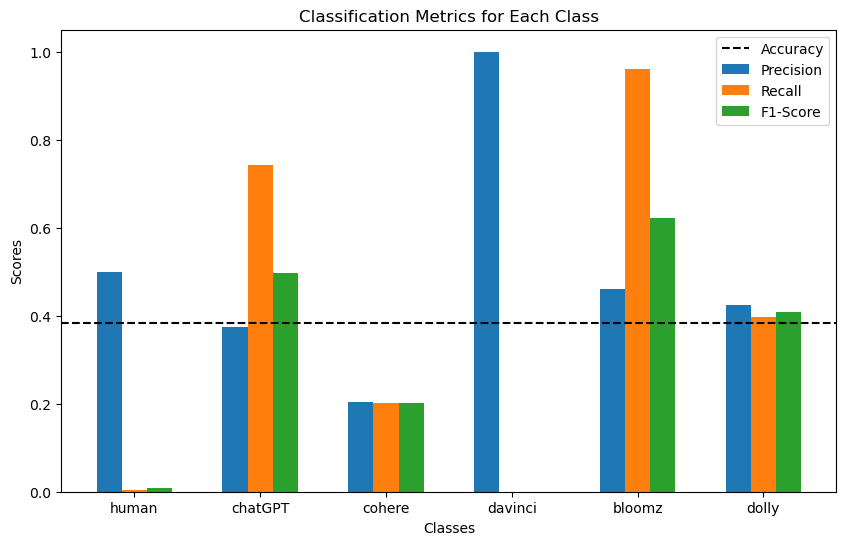

In [15]:
# Results data
classes = ['human', 'chatGPT', 'cohere', 'davinci', 'bloomz', 'dolly']
precision = [0.5, 0.3747474747474748, 0.20321931589537223, 1.0, 0.46065259117082535, 0.42398286937901497]
recall = [0.004, 0.742, 0.202, 0.0, 0.96, 0.396]
f1_score = [0.007936507936507936, 0.4979865771812081, 0.20260782347041123, 0.0, 0.6225680933852141, 0.4095139607032058]
accuracy = 0.384  
# Bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
bar_positions = np.arange(len(classes))
ax.bar(bar_positions - bar_width, precision, width=bar_width, label='Precision')
ax.bar(bar_positions, recall, width=bar_width, label='Recall')
ax.bar(bar_positions + bar_width, f1_score, width=bar_width, label='F1-Score')
# Add accuracy as a horizontal line
ax.axhline(y=accuracy, color='black', linestyle='--', label='Accuracy')
# Customize plot
ax.set_xticks(bar_positions)
ax.set_xticklabels(classes)
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Classification Metrics for Each Class')
ax.legend()
# Show the plot
plt.show()